# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
import numpy as np
import pandas as pd
import sys

from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from helpers import filename_for

Welcome to JupyROOT 6.16/00


In [2]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(train[train[label] == h]["nHits"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(train[train[label] == h]["nClus"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(train[train[label] == h]["Edep"], range=(0, 5000), bins=500, density=True,)[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [
            self._hits[h][x["nHits"]] * self._clus[h][x["nClus"]] * self._edep[h][x["Edep"].floordiv(10).astype(int)]
            for h in self._hypos
        ]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [3]:
files = [
    filename_for(15, 30, 600, 500, n, "inclxx", s, "trifeature.pkl") for n in range(1, 7) for s in range(20)
]
dfs = [pd.read_pickle(file) for file in files]
data = pd.concat(dfs, ignore_index=True)
data.loc[0] = data.loc[1] = [0, 0, 0, 0, 0, 0] # for n=0

## Example Fit / Calibration & Prediction

In [4]:
label = "nPN"
nmax = 4

In [5]:
subset = data[data[label] <= nmax]
msk = np.random.rand(len(subset)) < 0.8
msk[0] = True
msk[1] = False
traindata = subset[msk].sample(frac=1)
testdata = subset[~msk].sample(frac=1)

display(traindata)

,nPN,nPP,nPH,nHits,nClus,Edep
363786,2,1,1,12,7,225
723638,4,3,3,27,9,728
368259,2,2,2,38,13,537
794238,4,4,4,51,17,1264
641683,4,3,3,54,13,968
...,...,...,...,...,...,...
95720,1,1,1,9,6,181
471615,3,3,3,34,8,683
257948,2,2,2,51,20,731
675702,4,4,4,46,13,765


In [6]:
model = Bayes(traindata, nmax, label)
y_pred = model.predict(testdata)
y_true = testdata[label].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(3, 3), (1, 1), (2, 1), (2, 1), (4, 4), (1, 1), (4, 4), (2, 2), (3, 2), (1, 1), (1, 1), (3, 2), (3, 3), (1, 1), (4, 4), (3, 2), (3, 4), (3, 2), (4, 4), (3, 3), (4, 4), (4, 4), (2, 2), (1, 1), (4, 4), (4, 3), (1, 1), (2, 2), (3, 3), (3, 3), (2, 2), (4, 4), (4, 4), (4, 4), (2, 2), (3, 2), (3, 3), (4, 3), (2, 1), (1, 1), (2, 2), (3, 1), (2, 1), (1, 1), (2, 1), (1, 1), (2, 2), (1, 1), (1, 1), (2, 3)]


In [7]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print((cmrel * 100).round())

0.7300195819193229
[[    1     0     0     0     0]
 [ 1977 33831  4564    26     6]
 [   88  7953 24414  7751   243]
 [    8  1173  8988 19898 10071]
 [    7   147  1897  9374 28448]]
[[100.   0.   0.   0.   0.]
 [  5.  84.  11.   0.   0.]
 [  0.  20.  60.  19.   1.]
 [  0.   3.  22.  50.  25.]
 [  0.   0.   5.  24.  71.]]


Text(69.0, 0.5, 'True')

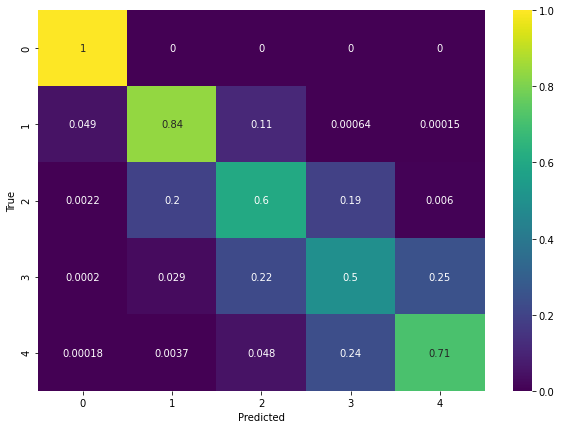

In [8]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

## Evaluation for different max multiplicities

In [9]:
for n in [1, 2, 3, 4, 5]:
    subset = data[data[label] <= n]
    msk = np.random.rand(len(subset)) < 0.8
    msk[0] = True
    msk[1] = False
    traindata = subset[msk].sample(frac=1)
    testdata = subset[~msk].sample(frac=1)

    model = Bayes(traindata, n, label)
    y_pred = model.predict(testdata)
    y_true = testdata[label].values.ravel()
    # print(list(zip(y_true, y_pred))[0:50])
    bac = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(0, n + 1))
    print(cm)
    print(n, bac)

[[    1     0]
 [ 2013 38072]]
1 0.9748908569290258
[[    1     0     0]
 [ 1964 33233  4532]
 [  103  7784 32414]]
2 0.8802632983330264
[[    1     0     0     0]
 [ 1986 33713  4510    42]
 [   89  7882 24209  7662]
 [   14  1114  9145 29701]]
3 0.7970505818323997
[[    1     0     0     0     0]
 [ 1957 33546  4557    37    13]
 [  105  7873 24178  7808   222]
 [    5  1160  9128 20074  9964]
 [    2   135  1858  9656 28328]]
4 0.7288611256269165
[[    1     0     0     0     0     0]
 [ 1959 33506  4621    30     5     4]
 [  101  7868 24316  7563   225     9]
 [    6  1170  9185 19869  9195   697]
 [    1   130  1988  9525 17384 11216]
 [    6    12   314  2539  9539 27580]]
5 0.676424813320358
